# Домашняя работа 8. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #8: Name Surname`. Если тема будет неправильная, то задание не будет проверено.
6. Дедлайн: 18.12.2017 01:00 OMSK
7. После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

Рассылка решений: 25.12.2017 17:00 OMSK
После рассылки задания почти совсем не имеют веса.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиции деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sbs
%matplotlib inline
pd.set_option('display.max_columns', 150)

A:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dt = pd.read_csv('./../data/winequality-red.csv.gz', compression='gzip', delimiter=';')
dt.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


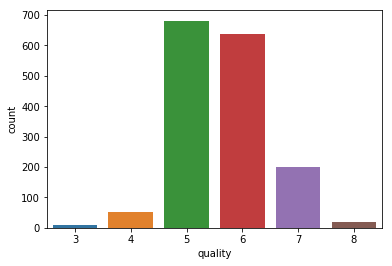

In [3]:
sbs.countplot(x='quality', data=dt)

Я думаю, что объектов классов 5 и 6 во много раз больше, чем объектов остальных классов.
Значит алгоритмы станут ошибаться больше на остальных классах.

In [4]:
X, y = dt.drop(['quality'], axis=1), dt.quality

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [5]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [6]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler().fit(X)
X1 = scaler.transform(X)

In [7]:
clf1 = KNeighborsClassifier(n_neighbors=10, n_jobs=3)
clf2 = KNeighborsClassifier(n_neighbors=10, n_jobs=3)
clf3 = RidgeClassifier(random_state=42)
clf4 = DecisionTreeClassifier(random_state=42)
clf5 = BaggingClassifier(n_estimators=100, n_jobs=3, random_state=42)
clf6 = BaggingClassifier(n_estimators=100, n_jobs=3, max_features=.5, random_state=42)
clf7 = RandomForestClassifier(n_estimators=100, n_jobs=3, random_state=42)

In [8]:
l = [
    (clf1, X, 'KNeighborsClassifier с 10 соседями'),
    (clf2, X1, 'KNeighborsClassifier с 10 соседями и масштабированием StandartScaler'),
    (clf3, X, 'RidgeClassifier'),
    (clf4, X, 'DecisionTreeClassifier'),
    (clf5, X, 'BaggingClassifier c 100 деревьев'),
    (clf6, X, 'BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков'),
    (clf7, X, 'RandomForestClassifier c 100 деревьев')
    ]

In [9]:
from tqdm import tqdm

In [10]:
scores = []
for x in tqdm(l):
    print(x[2])
    %time score = np.mean(cross_val_score(x[0], x[1], y, cv=kf, scoring='accuracy')); print('Accuracy: ', score)
    print()
    scores.append(score)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

KNeighborsClassifier с 10 соседями
Accuracy:  0.512219827586
Wall time: 712 ms



 14%|████████████                                                                        | 1/7 [00:00<00:04,  1.35it/s]

KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
Accuracy:  0.579753134796
Wall time: 632 ms



 29%|████████████████████████                                                            | 2/7 [00:01<00:03,  1.42it/s]

RidgeClassifier
Accuracy:  0.583538401254
Wall time: 665 ms



 43%|████████████████████████████████████                                                | 3/7 [00:02<00:02,  1.42it/s]

DecisionTreeClassifier
Accuracy:  0.618520768025
Wall time: 228 ms



 57%|████████████████████████████████████████████████                                    | 4/7 [00:02<00:01,  1.68it/s]

BaggingClassifier c 100 деревьев
Accuracy:  0.695460423197
Wall time: 42.4 s



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:44<00:17,  8.96s/it]

BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков
Accuracy:  0.69921630094
Wall time: 41.2 s



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [01:26<00:14, 14.34s/it]

RandomForestClassifier c 100 деревьев
Accuracy:  0.70109130094
Wall time: 6.15 s



100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:32<00:00, 13.18s/it]


In [11]:
mean_score = np.mean(scores)

print("Mean score =", mean_score, '\n')

for x in sorted(list(zip(scores, l)), key=lambda item: abs(item[0] - mean_score), reverse=True):
    print('%s:' % x[1][2])
    %time print("(mean_accuracy - accuracy of %s) =" % x[1][2], "abs(%f - %f) =" % (x[0], mean_score), abs(x[0] - mean_score))
    print()

Mean score = 0.627114308106 

KNeighborsClassifier с 10 соседями:
(mean_accuracy - accuracy of KNeighborsClassifier с 10 соседями) = abs(0.512220 - 0.627114) = 0.114894480519
Wall time: 32 ms

RandomForestClassifier c 100 деревьев:
(mean_accuracy - accuracy of RandomForestClassifier c 100 деревьев) = abs(0.701091 - 0.627114) = 0.0739769928348
Wall time: 36 ms

BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков:
(mean_accuracy - accuracy of BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков) = abs(0.699216 - 0.627114) = 0.0721019928348
Wall time: 32 ms

BaggingClassifier c 100 деревьев:
(mean_accuracy - accuracy of BaggingClassifier c 100 деревьев) = abs(0.695460 - 0.627114) = 0.0683461150918
Wall time: 48 ms

KNeighborsClassifier с 10 соседями и масштабированием StandartScaler:
(mean_accuracy - accuracy of KNeighborsClassifier с 10 соседями и масштабированием StandartScaler) 

In [12]:
#dot_data = export_graphviz(clf, feature_names=['Возраст'], filled=True, out_file=None)
#graphviz.Source(dot_data)

### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

Ответ: 

1. StandardScaler нормализует выборку, делая распределение близким к стандартному нормальному распределению, таким образом меняются сами случайные величины, расстояние между ними, что важно в линейных алгоритмах классификации(без нормализации признаки вносят разный вклад в исход предсказания, что ведет к переобучению).

2. Логические алгоритмы классификации ищут не формулу в виде линейной комбинации признаков, а логическую формулу, потому масштабирование не меняет качество алгоритма.

3. С полным набором признаков деревья могут переобучаться, потому отщепляется случайная часть признаков, чтобы найти наиболее информативные признаки и более качественные алгоритмы для выборки(для последующего голосования).

4. У "KNeighborsClassifier с 10 соседями". Потому, что предсказание слишком слабое, алгоритм метрический и вход не был нормализован(потому произошло "проклятие размерностей").

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [13]:
from sklearn.datasets import load_digits
from tqdm import tqdm_notebook
X, y = load_digits(return_X_y=True)

In [14]:
digits = load_digits()

In [15]:
len(X[1])

64

A Jupyter Widget

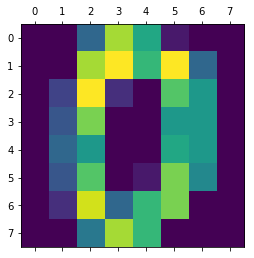

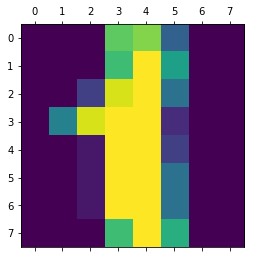

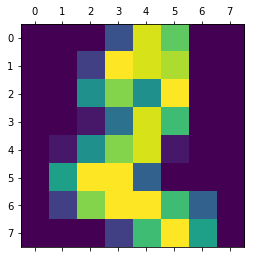

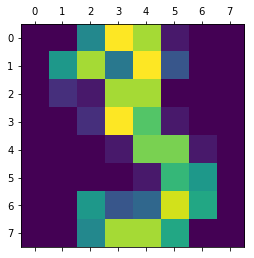

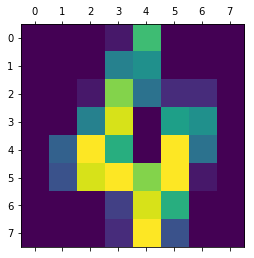

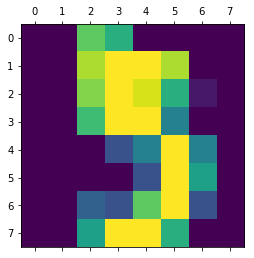

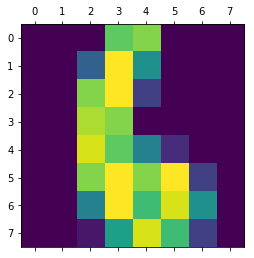

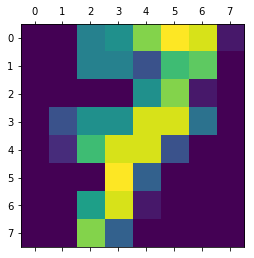

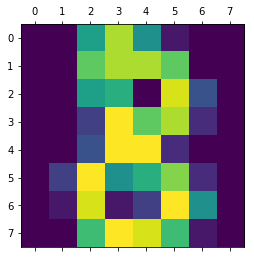

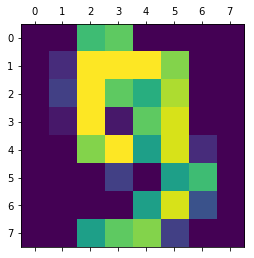

In [16]:
for i in tqdm_notebook(range(10)):
    plt.matshow(digits.images[i])
    plt.show()

# 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [17]:
from math import sqrt

In [18]:
clf1 = DecisionTreeClassifier(random_state=42)
clf2 = BaggingClassifier(n_estimators=100, n_jobs=3, random_state=42)
clf3 = BaggingClassifier(n_estimators=100, n_jobs=3, max_features=int(sqrt(len(X[0]))), random_state=42)
clf4 = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42, max_features=int(sqrt(len(X[0])))), 
                         n_estimators=100, n_jobs=3, #max_features=int(sqrt(len(X[0]))),
                         random_state=42)
clf5 = RandomForestClassifier(n_estimators=100, n_jobs=3, random_state=42)

In [20]:
l1 = [
    (clf1, 'DecisionTreeClassifier с параметрами по-умолчанию'),
    (clf2, 'BaggingClassifier c 100 деревьев'),
    (clf3, 'BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в √N, где N - это число признаков.'),
    (clf4, 'BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в √N, где N - это число признаков. Это отличается от предыдущей модели тем, где ограничивается max_features. Читайте документацию :trollface:'),
    (clf5, 'обычный случайный лес со 100 деревьями')
    ]

In [21]:
for x in tqdm(l1):
    print(x[1])
    %time print('Accuracy: ', np.mean(cross_val_score(x[0], X, y, cv=10, scoring='accuracy')))
    print()

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

DecisionTreeClassifier с параметрами по-умолчанию
Accuracy:  0.837085080214
Wall time: 615 ms



 20%|████████████████▊                                                                   | 1/5 [00:00<00:02,  1.56it/s]

BaggingClassifier c 100 деревьев
Accuracy:  0.926622379912
Wall time: 1min 27s



 40%|█████████████████████████████████▌                                                  | 2/5 [01:28<02:12, 44.21s/it]

BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в √N, где N - это число признаков.
Accuracy:  0.931169233525
Wall time: 1min 20s



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:48<01:52, 56.28s/it]

BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в √N, где N - это число признаков. Это отличается от предыдущей модели тем, где ограничивается max_features. Читайте документацию :trollface:
Accuracy:  0.953332102247
Wall time: 1min 27s



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:16<01:04, 64.21s/it]

обычный случайный лес со 100 деревьями
Accuracy:  0.953310668872
Wall time: 12 s



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:28<00:00, 53.79s/it]


### 2.3 В чём разница? (3 балла)

Ответьте на вопрос: я считаю, что в первом случае мы оставляем для всей модели некоторые признаки, значит подмодели могут пользоваться только признаками отобранными на уровне выше. А во втором случае для модели доступны все признаки, но здесь уже подмодели могут иметь разные информативные признаки(их некое, ограниченное исследователем число) в аммуниции, что и позволяет построить более точную модель.

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClassifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

![](https://i.ytimg.com/vi/_5GWMIAHc08/hqdefault.jpg)

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [22]:
n_estimators = [1, 5, 10, 15, 50, 100, 150, 200, 300]
accs = []
for n in tqdm(n_estimators):
    print("Random Forest Classifier with %d estimators" % n)
    clf = RandomForestClassifier(n_estimators=n, n_jobs=3, random_state=42)
    accs.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
    print('Accuracy: ', accs[len(accs) - 1])

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

Random Forest Classifier with 1 estimators
Accuracy:  0.761635733552


 11%|█████████▎                                                                          | 1/9 [00:01<00:10,  1.33s/it]

Random Forest Classifier with 5 estimators
Accuracy:  0.883702869674


 22%|██████████████████▋                                                                 | 2/9 [00:03<00:13,  1.97s/it]

Random Forest Classifier with 10 estimators
Accuracy:  0.927202121785


 33%|████████████████████████████                                                        | 3/9 [00:06<00:13,  2.25s/it]

Random Forest Classifier with 15 estimators
Accuracy:  0.941717861426


 44%|█████████████████████████████████████▎                                              | 4/9 [00:09<00:12,  2.45s/it]

Random Forest Classifier with 50 estimators
Accuracy:  0.955011386465


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:16<00:13,  3.28s/it]

Random Forest Classifier with 100 estimators
Accuracy:  0.953310668872


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:28<00:14,  4.79s/it]

Random Forest Classifier with 150 estimators
Accuracy:  0.948331555706


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:45<00:13,  6.51s/it]

Random Forest Classifier with 200 estimators
Accuracy:  0.949973868701


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [01:07<00:08,  8.48s/it]

Random Forest Classifier with 300 estimators
Accuracy:  0.951622990901


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:39<00:00, 11.01s/it]


optimal n_estimators = 50


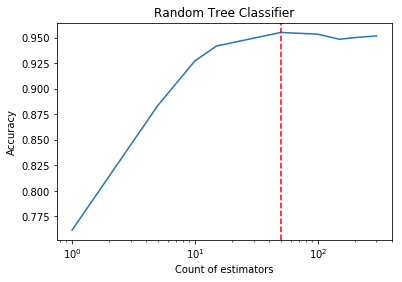

In [23]:
opt_n = sorted(list(zip(accs, n_estimators)), reverse=True)[0][1]
print('optimal n_estimators =', opt_n)

plt.plot(n_estimators, accs)

plt.title('Random Tree Classifier')
plt.ylabel('Accuracy')
plt.xlabel('Count of estimators')
plt.axvline(opt_n, color='r', ls='--')
plt.xscale('log')

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Random Forest Classifier with 1 max_features
Accuracy:  0.883184824079


  7%|█████▉                                                                             | 1/14 [00:02<00:37,  2.87s/it]

Random Forest Classifier with 6 max_features
Accuracy:  0.915540550883


 14%|███████████▊                                                                       | 2/14 [00:05<00:34,  2.88s/it]

Random Forest Classifier with 11 max_features
Accuracy:  0.921564874229


 21%|█████████████████▊                                                                 | 3/14 [00:08<00:31,  2.88s/it]

Random Forest Classifier with 16 max_features
Accuracy:  0.915566581478


 29%|███████████████████████▋                                                           | 4/14 [00:11<00:28,  2.89s/it]

Random Forest Classifier with 21 max_features
Accuracy:  0.922683744227


 36%|█████████████████████████████▋                                                     | 5/14 [00:14<00:25,  2.88s/it]

Random Forest Classifier with 26 max_features
Accuracy:  0.918239867368


 43%|███████████████████████████████████▌                                               | 6/14 [00:17<00:23,  2.89s/it]

Random Forest Classifier with 31 max_features
Accuracy:  0.921161033475


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:20<00:20,  2.90s/it]

Random Forest Classifier with 36 max_features
Accuracy:  0.913802507843


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:23<00:17,  2.93s/it]

Random Forest Classifier with 41 max_features
Accuracy:  0.920446236431


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:26<00:14,  3.00s/it]

Random Forest Classifier with 46 max_features
Accuracy:  0.92610036917


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:30<00:12,  3.08s/it]

Random Forest Classifier with 51 max_features
Accuracy:  0.917161578054


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:34<00:09,  3.16s/it]

Random Forest Classifier with 56 max_features
Accuracy:  0.915662354878


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:38<00:06,  3.23s/it]

Random Forest Classifier with 61 max_features
Accuracy:  0.910148654566


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:42<00:03,  3.29s/it]

Random Forest Classifier with 64 max_features
Accuracy:  0.900139057226


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:46<00:00,  3.34s/it]


optimal max_features = 46


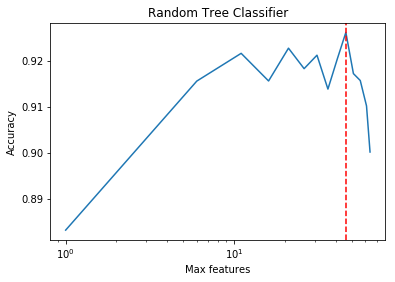

In [24]:
max_features = np.array((np.arange(64, step=5) + 1).tolist() + [64])
accs = []
for n in tqdm(max_features):
    print("Random Forest Classifier with %d max_features" % n)
    clf = RandomForestClassifier(max_features=n, n_jobs=3, random_state=42)
    accs.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
    print('Accuracy: ', accs[len(accs) - 1])

opt_n = sorted(list(zip(accs, max_features)), reverse=True)[0][1]
print('optimal max_features =', opt_n)

plt.plot(max_features, accs)

plt.title('Random Tree Classifier')
plt.ylabel('Accuracy')
plt.xlabel('Max features')
plt.axvline(opt_n, color='r', ls='--')
plt.xscale('log')

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

Ответ:
1. С ростом числа деревьев увеличивается точность, но в определенный момент доля верных ответов выходит на асимптоту, так что большее, чем некоторое(в зависимости от задачи и epsilon для отклонений) число деревьев не нужно(да и вычислительно более сложно).

2. Согласно статье(https://habrahabr.ru/company/ods/blog/324402/#2-sluchaynyy-les) происходит увеличение, а позже выход на асимптоту, но в нашем случае происходит падение качества после примерного достижения отметки в $\sqrt{Count of features}$.

3. В зависимости от max_features дерево может использовать в своей структуре как смешанные(при большом значении гиперпараметра), так и более простые зависимости(при малом значении, к примеру, дерево отыскивает какого класса объекты по одному признаку). При очень большом или очень малом значении max_features дерево имеет большую возможность переобучиться и запомнить некоторые не очень важные моменты(естественно при достаточной глубине дерева и т.п.).

4. Согласно статье ODS, этот параметр хорошо справляется с регуляризацией модели, потому что алгоритм имеет меньше возможности запомнить все нюансы о признаках объекта и таким образом переобучиться.

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)